In [37]:
import pandas as pd
import numpy as np
from sqlalchemy import engine
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
conn_string = r"postgresql://masterschool-analyst:pa84cc0d01e9b241460abdf838bb34f5932c9473dca571b56fcb13dd3023a62e0@ec2-52-4-84-108.compute-1.amazonaws.com:5432/da541q56oobji4"
connection = engine.create_engine(conn_string)

In [39]:
query = """select * from mat_orders"""

df = pd.read_sql(query, con=conn_string)

In [40]:
cte_query = """
  SELECT 
    order_id, 
    partner_id AS operator_id, 
    partner_name AS operator_name, 
    status, 
    m.source, 
    fullname, 
    email AS customer_email, 
    company_name, 
    confirmation_id, 
    space_id, 
    space_name, 
    created_at, 
    promotion_code, 
    total_price AS final_price, 
    --not usd,  sub_total + tax_amount, sub_total=order_line_item_total_price
    ABS(discounted_amount) AS discounted_amount, 
    --not usd
    total_price_in_usd AS final_price_usd, 
    --amount transacted through Flexspace
    ABS(ROUND(
      discounted_amount * to_usd_rate, 2
    )) AS discounted_amount_usd, 
    ROUND(
      (
        total_price_in_usd + ABS(discounted_amount * to_usd_rate)
      ), 
      2
    ) AS original_price_usd, 
    processing_fee_in_usd, 
    to_usd_rate, 
    location_id, 
    location_name_en, 
    location_time_zone, 
    country, 
    m.state, 
    city, 
    order_line_item_id, 
    orderable_type, 
    orderable_id, 
    order_line_item_details, 
    access_id, 
    booking_product_type, 
    product_type_id, 
    add_on_days_to_expire, 
    capacity, 
    booking_id, 
    start_date, 
    end_date, 
    date, 
    quantity, 
    last_refresh 
  FROM 
    mat_orders AS m 
  WHERE 
    status = 'paid' 
    AND email NOT IN (
      SELECT 
        email 
      FROM 
        mat_orders 
      WHERE 
        1 = 1 
        AND (
          company_name ILIKE '%%test%%'
          OR fullname ILIKE '%%test%%' 
          OR email ILIKE '%%test%%' 
          OR promotion_code ILIKE '%%test%%'
          OR partner_name ILIKE '%%test%%'
        )
    ) 
    AND m.source IN ('WL', 'FM')
    AND created_at < '2023-07-01'
;

"""

filtered_df = pd.read_sql(cte_query, con=conn_string)

In [41]:
fdf = filtered_df

In [42]:
# Convert 'date' to a time stamp
fdf['date'] = pd.to_datetime(fdf['date'])

In [43]:
fdf['operator_key'] = fdf['country']+"-"+np.where(fdf['state'].isin([None]),"", fdf['state']+"-")+fdf['city']
fdf['operator_full_name'] = fdf['operator_name']+"-"+fdf['country']+"-"+np.where(fdf['state'].isin([None]),"", fdf['state']+"-")+fdf['city']+"-"+fdf['space_name']


In [44]:
fdf.head()

,order_id,operator_id,operator_name,status,source,fullname,customer_email,company_name,confirmation_id,space_id,...,add_on_days_to_expire,capacity,booking_id,start_date,end_date,date,quantity,last_refresh,operator_key,operator_full_name
0,f4d3f3f4-4d68-495e-a32d-a9da7074e71e,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Marc Tuduri,marctc@pm.me,Grafana,59589bee,a799d215-583a-495c-bb0e-7940ede0c38c,...,NaN,1.0,b870fc5b-340a-4e32-ae63-e52d1b6275fa,2022-08-24,2022-08-24,NaT,1.0,2023-08-17 02:45:00.391652+00:00,DE-Berlin,Mindspace-DE-Berlin-Mindspace Daily - Skalitzer
1,f0d4a64b-ce9b-49a0-896a-5bade15f91db,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Robert,robberry918@gmail.com,Robert Berry,f413f76c,a2c2cc53-d34b-4fc0-8ca3-546b8b027a5a,...,NaN,1.0,3da80a1c-2968-4574-9253-fcd7e0338f90,2022-10-21,2022-10-21,NaT,1.0,2023-08-17 02:45:00.391652+00:00,US-DC-Washington,Mindspace-US-DC-Washington-Mindspace Daily - K...
2,22a7a9fa-1ac7-4029-9922-969de5c86168,197e925e-58c4-4b26-a533-0ef8b204cef4,Urban Place,paid,WL,Ronit Zimmer,Ronit@projectrozana.org,Project Rozana,7cdff055,88a82f51-4d05-4959-9bcc-afbdd786b1e6,...,NaN,1.0,d3c02dc8-fd09-48e3-84fd-61cab695d7b0,2022-11-21,2022-11-21,NaT,2.0,2023-08-17 02:45:00.391652+00:00,IL-Jerusalem,Urban Place-IL-Jerusalem-UP Day Pass
3,b9fc66bc-4dc4-4525-96f1-2a73f847f81f,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Leonard Witteler,leonard@witteler.org,nxz91 capital ug,4047dcc6,3299dac1-0380-448e-8b8b-07393fbef811,...,NaN,1.0,4ddc89db-390f-4343-9ce7-c097ecda02d3,2023-03-09,2023-03-09,NaT,1.0,2023-08-17 02:45:00.391652+00:00,DE-Berlin,Mindspace-DE-Berlin-Mindspace Daily - Friedric...
4,809fe65a-8087-48ed-bf62-ed1f4a433cc5,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Tessa Nijdam,hello@tessanijdam.com,Tessa Nijdam,450e7ee5,a799d215-583a-495c-bb0e-7940ede0c38c,...,NaN,1.0,463d4629-e16b-4cad-a02f-2651ad3117e4,2023-01-23,2023-01-23,NaT,1.0,2023-08-17 02:45:00.391652+00:00,DE-Berlin,Mindspace-DE-Berlin-Mindspace Daily - Skalitzer


In [45]:
def create_extended_rfm_by(fdf_, key="operator_name"):

    # this is a bogus filter - you can change that however you like
    fdf_filtered = fdf_[fdf_['date'] < pd.to_datetime('2023-07-01')].copy()
    
    #recency and lifetime
    df_recency = fdf_filtered.groupby(key)['date'].agg(["max", "min"]).reset_index()
    df_recency.columns = ['operator', 'last_order', "first_order"]
    
    df_recency['recency'] = (pd.Timestamp.now().normalize() - df_recency['last_order']).dt.days
    df_recency['lifetime'] = (df_recency['last_order'] - df_recency['first_order']).dt.days+1
    
    #monetary and frequency 
    df_monetary_freq = fdf_filtered.groupby(key)['final_price_usd'].agg(['count', sum]).copy().reset_index()
    df_monetary_freq.columns = ['operator', 'frequency', "monetary"]

    
    # Count number of orders for each customer and partner
    df_orders = fdf_filtered.groupby([key, 'customer_email']).size().reset_index(name='orders')
    # Calculate whether the customer has returned (1 if 'orders' > 1, 0 otherwise)
    df_orders['returned'] = (df_orders['orders'] > 1).astype(int)

    # Now group by partner_name and calculate total customers and returning customers
    df_final = df_orders.groupby(key).agg(total_customers=('customer_email', 'count'), returning_customers=('returned', 'sum')).reset_index()
    df_final['return_rate'] = df_final['returning_customers'] / df_final['total_customers']
    #df_final = df_final.drop(['returning_customers', 'total_customers'], axis=1).copy()
    df_final.columns = ['operator', "total_customers", "returning_customers", "return_rate"]
    
    df = df_recency.merge(df_monetary_freq).merge(df_final).copy()
    df = df.drop(['last_order','first_order','returning_customers'], axis=1)
    df['intensity'] = df['frequency']/df['lifetime']
    return df



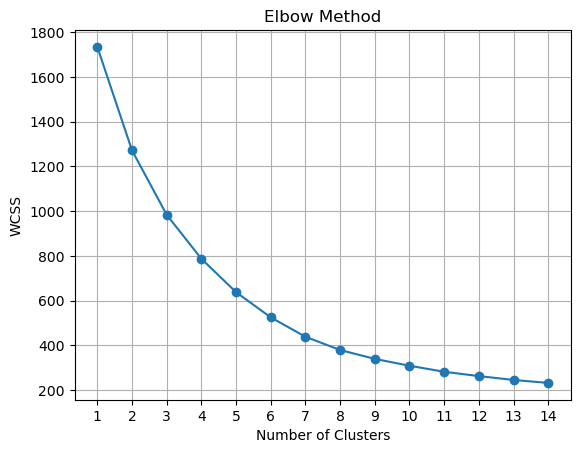

In [51]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Call the create_extended_rfm_by function
fdf_rfm = create_extended_rfm_by(fdf, key="operator_full_name")

# Selecting the columns for clustering
selected_columns = ['recency', 'lifetime', 'frequency', 'monetary', 'return_rate', 'intensity']
X = fdf_rfm[selected_columns]

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Using the elbow method to find the optimal number of clusters
wcss = [] # Within-cluster sum of squares
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the results
plt.plot(range(1, 15), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 15))
plt.grid(True)
plt.show()


In [52]:
fdf_rfm

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
0,Bond Collective-US-CA-Los Angeles-Rialto,48,29,2,637.5,2,0.000000,0.068966
1,Bond Collective-US-IL-Chicago-Haymarket,117,1,1,300.0,1,0.000000,1.000000
2,Bond Collective-US-IL-Chicago-Humboldt,48,72,3,550.0,3,0.000000,0.041667
3,Bond Collective-US-IL-Chicago-Lakeview,50,16,2,800.0,2,0.000000,0.125000
4,Bond Collective-US-IL-Chicago-Noble,91,1,1,100.0,1,0.000000,1.000000
...,...,...,...,...,...,...,...,...
284,Werqwise-US-CA-San Mateo-Meeting Room B2,47,486,3,1860.0,3,0.000000,0.006173
285,Werqwise-US-CA-San Mateo-Rooftop Meeting Room,56,490,19,11181.5,14,0.285714,0.038776
286,Workuity-US-AZ-Chandler-Four Peaks – Blue,48,2,2,825.0,1,1.000000,1.000000
287,gSpace-US-CT-Fairfield-Meeting Room 1,51,60,5,1150.0,2,0.500000,0.083333


In [55]:
# Choose the optimal number of clusters (k = 5) based on the elbow method
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add the clusters to the DataFrame used for clustering
fdf_rfm['cluster'] = clusters

# Rename the 'operator' column in fdf_rfm to match the key in fdf
fdf_rfm.rename(columns={'operator': 'operator_full_name'}, inplace=True)

# Merge the clusters back to the original DataFrame, using 'operator_full_name' as the key
fdf = fdf.merge(fdf_rfm[['cluster', 'operator_full_name']], on='operator_full_name', how='left')




In [58]:
fdf.head()

,order_id,operator_id,operator_name,status,source,fullname,customer_email,company_name,confirmation_id,space_id,...,capacity,booking_id,start_date,end_date,date,quantity,last_refresh,operator_key,operator_full_name,cluster
0,f4d3f3f4-4d68-495e-a32d-a9da7074e71e,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Marc Tuduri,marctc@pm.me,Grafana,59589bee,a799d215-583a-495c-bb0e-7940ede0c38c,...,1.0,b870fc5b-340a-4e32-ae63-e52d1b6275fa,2022-08-24,2022-08-24,NaT,1.0,2023-08-17 02:45:00.391652+00:00,DE-Berlin,Mindspace-DE-Berlin-Mindspace Daily - Skalitzer,NaN
1,f0d4a64b-ce9b-49a0-896a-5bade15f91db,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Robert,robberry918@gmail.com,Robert Berry,f413f76c,a2c2cc53-d34b-4fc0-8ca3-546b8b027a5a,...,1.0,3da80a1c-2968-4574-9253-fcd7e0338f90,2022-10-21,2022-10-21,NaT,1.0,2023-08-17 02:45:00.391652+00:00,US-DC-Washington,Mindspace-US-DC-Washington-Mindspace Daily - K...,NaN
2,22a7a9fa-1ac7-4029-9922-969de5c86168,197e925e-58c4-4b26-a533-0ef8b204cef4,Urban Place,paid,WL,Ronit Zimmer,Ronit@projectrozana.org,Project Rozana,7cdff055,88a82f51-4d05-4959-9bcc-afbdd786b1e6,...,1.0,d3c02dc8-fd09-48e3-84fd-61cab695d7b0,2022-11-21,2022-11-21,NaT,2.0,2023-08-17 02:45:00.391652+00:00,IL-Jerusalem,Urban Place-IL-Jerusalem-UP Day Pass,NaN
3,b9fc66bc-4dc4-4525-96f1-2a73f847f81f,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Leonard Witteler,leonard@witteler.org,nxz91 capital ug,4047dcc6,3299dac1-0380-448e-8b8b-07393fbef811,...,1.0,4ddc89db-390f-4343-9ce7-c097ecda02d3,2023-03-09,2023-03-09,NaT,1.0,2023-08-17 02:45:00.391652+00:00,DE-Berlin,Mindspace-DE-Berlin-Mindspace Daily - Friedric...,NaN
4,809fe65a-8087-48ed-bf62-ed1f4a433cc5,7041dd96-032c-4284-bb6f-cd48f207b956,Mindspace,paid,WL,Tessa Nijdam,hello@tessanijdam.com,Tessa Nijdam,450e7ee5,a799d215-583a-495c-bb0e-7940ede0c38c,...,1.0,463d4629-e16b-4cad-a02f-2651ad3117e4,2023-01-23,2023-01-23,NaT,1.0,2023-08-17 02:45:00.391652+00:00,DE-Berlin,Mindspace-DE-Berlin-Mindspace Daily - Skalitzer,NaN


In [59]:
cluster_summary = fdf_rfm.groupby('cluster')[selected_columns].mean()
print(cluster_summary)

            recency    lifetime  frequency      monetary  return_rate  \
cluster                                                                 
0         52.071429  479.357143  65.142857  16709.620000     0.212488   
1         83.076087  403.945652  15.923913   4559.228370     0.215172   
2        139.885965  144.236842   4.508772   1072.010877     0.055750   
3         96.952381  107.952381   4.000000    786.492381     0.730159   
4        159.958333    1.208333   1.083333    289.499583     0.000000   

         intensity  
cluster             
0         0.150107  
1         0.042814  
2         0.054874  
3         0.210050  
4         0.971875  


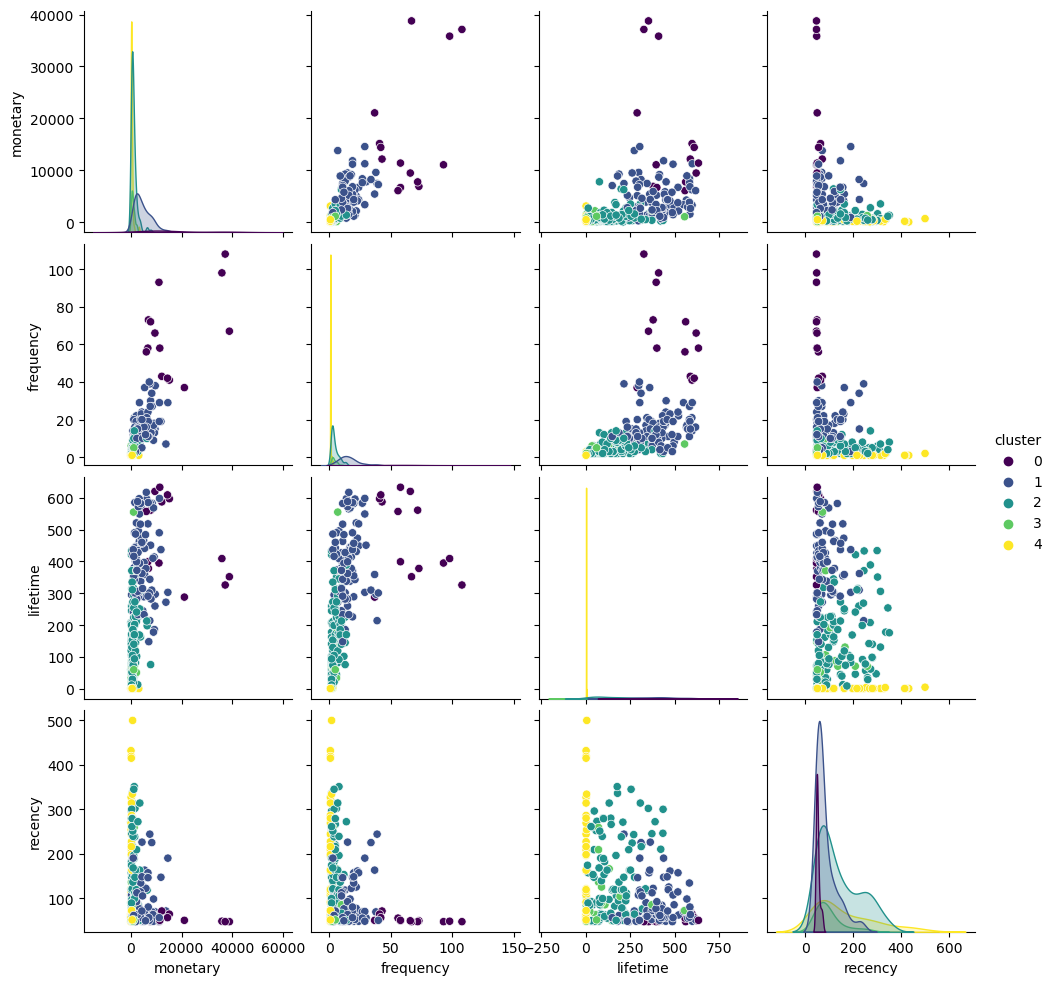

In [60]:
import seaborn as sns

subset_columns = ['monetary', 'frequency', 'lifetime', 'recency']
sns.pairplot(fdf_rfm, hue='cluster', vars=subset_columns, palette='viridis')
plt.show()


- Cluster 0: "big_fish"
    - High Frequency & High Spending
- Cluster 1: "loyalist"
    - Moderate Frequency & Moderate Spending
- Cluster 2: "still_young"
    - Low Frequency & Low Spending
    - Longer Lifetime
- Cluster 3: "churn"
    - Low Frequency & Low Spending
    - High Return Rate
- Cluster 4: "new"
    - Very Recent, Very Low Frequency & Spending

In [62]:
# Define a dictionary to map cluster numbers to segment names
segment_mapping = {
    0: 'big_fish',
    1: 'loyalist',
    2: 'still_young',
    3: 'churn',
    4: 'new'
}

# Apply the mapping to the 'cluster' column to create a new 'segment' column
fdf_rfm['segment'] = fdf_rfm['cluster'].map(segment_mapping)

fdf_rfm.head()


,operator_full_name,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity,cluster,segment
0,Bond Collective-US-CA-Los Angeles-Rialto,48,29,2,637.5,2,0.0,0.068966,2,still_young
1,Bond Collective-US-IL-Chicago-Haymarket,117,1,1,300.0,1,0.0,1.000000,4,new
2,Bond Collective-US-IL-Chicago-Humboldt,48,72,3,550.0,3,0.0,0.041667,2,still_young
3,Bond Collective-US-IL-Chicago-Lakeview,50,16,2,800.0,2,0.0,0.125000,2,still_young
4,Bond Collective-US-IL-Chicago-Noble,91,1,1,100.0,1,0.0,1.000000,4,new


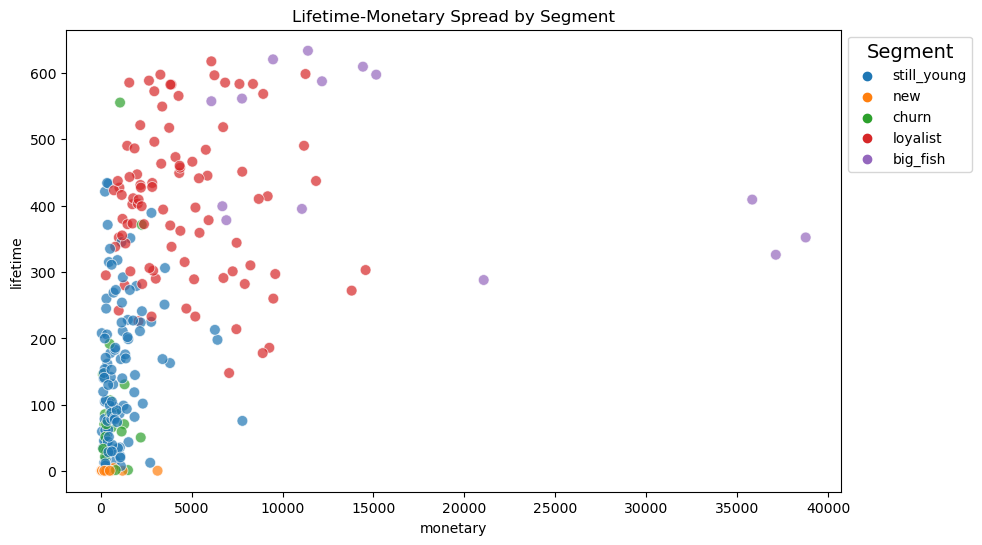

In [64]:

plt.figure(figsize=(10,6))
ax = sns.scatterplot(data=fdf_rfm, x='monetary', y='lifetime', hue='segment', palette='tab10', s=60, alpha=0.7, legend='full')
plt.title("Lifetime-Monetary Spread by Segment")

# Legend
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Segment')
legend.get_title().set_fontsize('14')  

plt.show()

In [66]:
# Group by the 'cluster' column and calculate the mean for the relevant columns
cluster_summary = fdf_rfm.groupby('cluster')[['recency', 'lifetime', 'frequency', 'monetary', 'return_rate', 'intensity']].mean()

# Map the segment names to the cluster summary
cluster_summary['segment'] = cluster_summary.index.map(segment_mapping)

# Reorder columns
cluster_summary = cluster_summary[['segment', 'recency', 'lifetime', 'frequency', 'monetary', 'return_rate', 'intensity']]

# Reset index for better presentation
cluster_summary.reset_index(drop=True, inplace=True)

cluster_summary


,segment,recency,lifetime,frequency,monetary,return_rate,intensity
0,big_fish,52.071429,479.357143,65.142857,16709.620000,0.212488,0.150107
1,loyalist,83.076087,403.945652,15.923913,4559.228370,0.215172,0.042814
2,still_young,139.885965,144.236842,4.508772,1072.010877,0.055750,0.054874
3,churn,96.952381,107.952381,4.000000,786.492381,0.730159,0.210050
4,new,159.958333,1.208333,1.083333,289.499583,0.000000,0.971875


- Cluster 0: "big_fish"
    - High Frequency & High Spending
- Cluster 1: "loyalist"
    - Moderate Frequency & Moderate Spending
- Cluster 2: "still_young"
    - Low Frequency & Low Spending
    - Longer Lifetime
- Cluster 3: "churn"
    - Low Frequency & Low Spending
    - High Return Rate
- Cluster 4: "new"
    - Very Recent, Very Low Frequency & Spending

- Big Fish:
    - average frequency of ~65 and average monetary of ~16,000
- Loyalist:
    - average frequency of ~15 and average monetary of ~4,500
- Still Young:
    - average frequency of ~4, average spending of ~1,000, and average lifetime of ~144
- Churn:
    - average frequency of ~4, average monetary of ~800, return rate of ~73%
- New:
- average recency of ~160, average frequency of ~1, and average monetary of ~300